<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_TP1_GRUPO02_ENTREGA_N3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


<font color='#fa5050'>Importante: para correr este notebook es pre-requisito haber corrido el notebook numero 1, ya que de lo contrario no se tienen los datasets de train y test.</font>

# Importación de librerias

In [148]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

# Lectura de archivo

### Desde google drive

In [149]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"

train_file = drive_path + '/Dataset/ds_train.csv'
test_file = drive_path + '/Dataset/ds_test.csv'
ds_cluster_train_file = drive_path + '/Dataset/ds_cluster_train.csv'
ds_cluster_3_file = drive_path + '/Dataset/ds_cluster_3_groups.csv'
barrios_file = drive_path + '/Dataset/barrios.csv'

ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
ds_train = pd.read_csv(train_file)
ds_test = pd.read_csv(test_file)
ds_cluster_train = pd.read_csv(ds_cluster_train_file)
ds_cluster_3 = pd.read_csv(ds_cluster_3_file)
using_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [134]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# train_file = './dataset/ds_train.csv'
# test_file = './dataset/ds_test.csv'
# ds_cluster_train_file = './dataset/ds_cluster_train.csv'
# ds_cluster_3_file = './dataset/ds_cluster_3_groups.csv'
# barrios_file = './dataset/barrios.csv'

# ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
# ds_train = pd.read_csv(train_file)
# ds_test = pd.read_csv(test_file)
# ds_cluster_train = pd.read_csv(ds_cluster_train_file)
# ds_cluster_3 = pd.read_csv(ds_cluster_3_file)
# using_drive = False

# Clasificación <font color='#fa5050'>(En progreso)</font>


## Construcción del target <font color='#fa5050'>(En progreso)</font>

In [135]:
ds_target = ds_train.copy()

### Creacion de la columna `'precio por metro cuadrado'`

In [136]:
ds_target['pxm2'] = ds_target['property_price'] / ds_target['property_surface_total']

### Evaluacion de limites de categorias de precio

Division igual entre todas las observaciones

In [137]:
ds_target['tipo_precio_1'] = pd.qcut(ds_target['pxm2'], q=3, labels=['bajo', 'medio', 'alto'])
ds_target['tipo_precio_1'].value_counts()

tipo_precio_1
bajo     24121
alto     24075
medio    24028
Name: count, dtype: int64

**Los Q's no tienen exactamente la misma cantidad ya que hay valores duplicados los cuales no pueden pertenecer a diferentes tipos, y hacen que no se pueda hacer una division perfecta.**

Division en 25% - 50% - 25% de observaciones

In [138]:
ds_target['tipo_precio_2'] = pd.qcut(ds_target['pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])
ds_target['tipo_precio_2'].value_counts()

tipo_precio_2
medio    36097
bajo     18084
alto     18043
Name: count, dtype: int64

Division en 25% - 50% - 25% relativo por cada tipo de propiedad

In [139]:
ds_target['tipo_precio_3'] = '' # inicializo todos a ''

# Con Departamentos
departamentos = ds_target['property_type'] == 'Departamento'
ds_target.loc[departamentos, 'tipo_precio_3'] = pd.qcut(ds_target.loc[departamentos, 'pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])

# Con Casas
casas = ds_target['property_type'] == 'Casa'
ds_target.loc[casas, 'tipo_precio_3'] = pd.qcut(ds_target.loc[casas, 'pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])

# Con PHs
phs = ds_target['property_type'] == 'PH'
ds_target.loc[phs, 'tipo_precio_3'] = pd.qcut(ds_target.loc[phs, 'pxm2'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])

ds_target['tipo_precio_3'].value_counts()

tipo_precio_3
medio    36130
bajo     18059
alto     18035
Name: count, dtype: int64

* Distribucion del precio por metro cuadrado

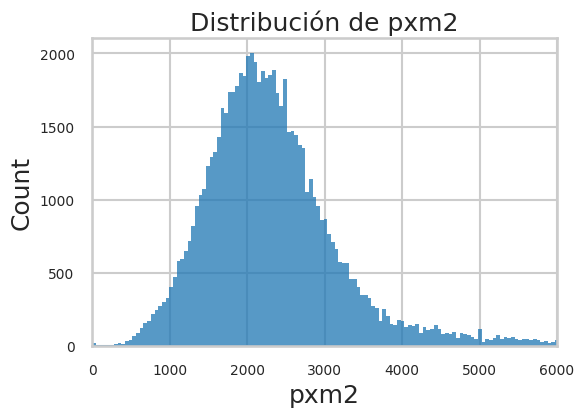

In [140]:
plt.figure(figsize=(6, 4))
sns.histplot(ds_target['pxm2'])
plt.title('Distribución de pxm2')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlim(0, 6000)
plt.show()

Se observa una *distribucion normal* con forma de campana de Gauss en la variable pxm2.

* Distribución del precio por metro cuadrado por tipo de propiedad

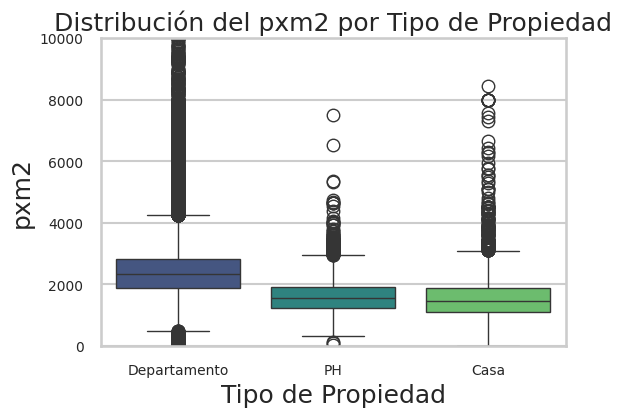

In [141]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='property_type', y='pxm2', data=ds_target, palette='viridis')
plt.title('Distribución del pxm2 por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('pxm2')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylim(0, 10000)
plt.show()

* Distribucion de categoria de precio por metodo

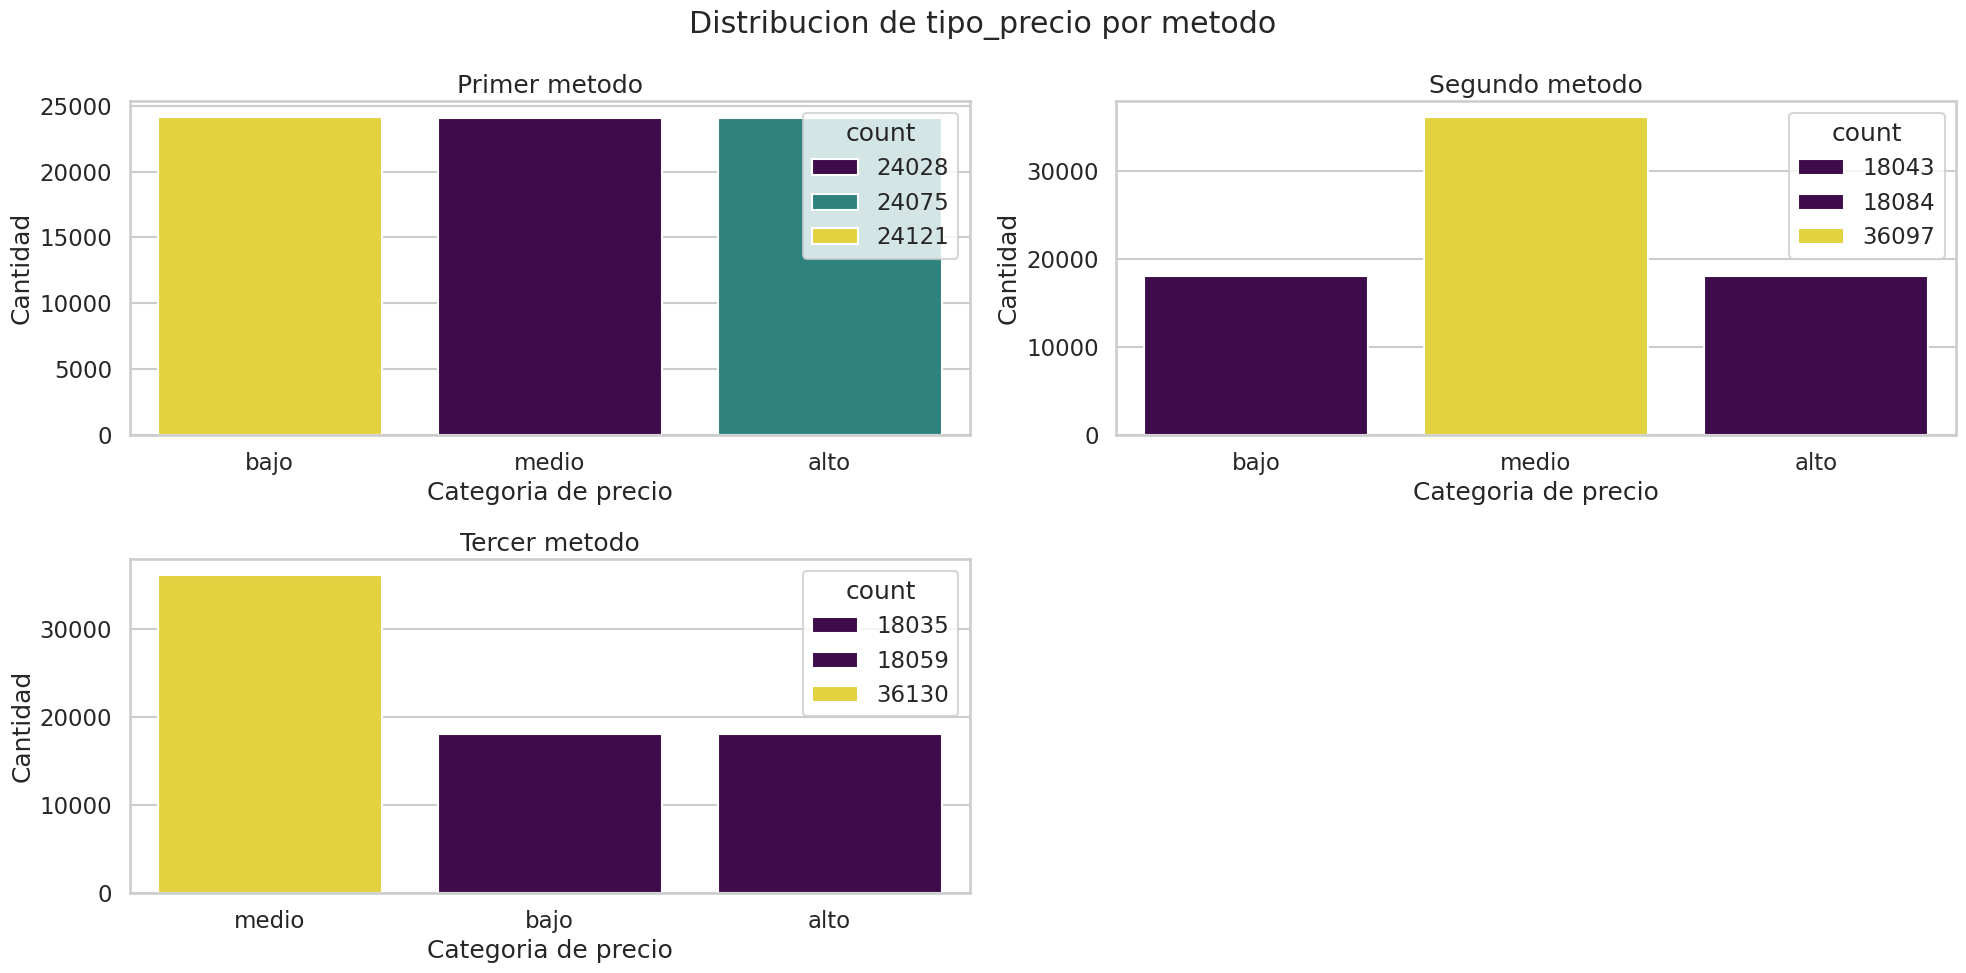

In [142]:
plt.figure(figsize=(20, 10))
plt.suptitle('Distribucion de tipo_precio por metodo')

# Primer metodo
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = ds_target["tipo_precio_1"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.index, y=frecuencias_place_3.values, hue=frecuencias_place_3, palette='viridis')
plt.title('Primer metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

# Segundo metodo
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = ds_target["tipo_precio_2"].value_counts()
sns.barplot(x=frecuencias_place_4.index, y=frecuencias_place_4.values, hue=frecuencias_place_4, palette='viridis')
plt.title('Segundo metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

# Tercer metodo
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = ds_target["tipo_precio_3"].value_counts()
sns.barplot(x=frecuencias_property_type.index, y=frecuencias_property_type.values, hue=frecuencias_property_type, palette='viridis')
plt.title('Tercer metodo')
plt.xlabel('Categoria de precio')
plt.ylabel('Cantidad')

plt.tight_layout()
plt.show()

### Seleccion de uno de los metodos vistos

Se decidira tomar el **ultimo metodo *(metodo 3)*** ya que tiene en cuenta no solo el ratio *precio/metros cuadrados* sino tambien que tipo de propiedad es, de esta manera se le asigna una clasificacion de precio mucho mas especifica que las otras dos alternativas.

Ej: *Los dos anteriores no tienen en cuenta que un precio X puede ser elevado para un departamento pero barato para un PH.*

In [143]:
# Eliminar categorias de precios de los metodos descartados
columnas_a_eliminar = ['tipo_precio_1', 'tipo_precio_2']
ds_target.drop(columns=columnas_a_eliminar, inplace=True)

# renombrar columna de tipo_precio del metodo a usar
ds_target['tipo_precio'] = ds_target['tipo_precio_3']
ds_target.drop(columns=['tipo_precio_3'], inplace=True)

In [144]:
# Vemos las cols
ds_target.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l3                     object
property_type                object
property_rooms                int64
property_bedrooms             int64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
pxm2                        float64
tipo_precio                  object
dtype: object

### Comparacion con Clusterizacion K=3

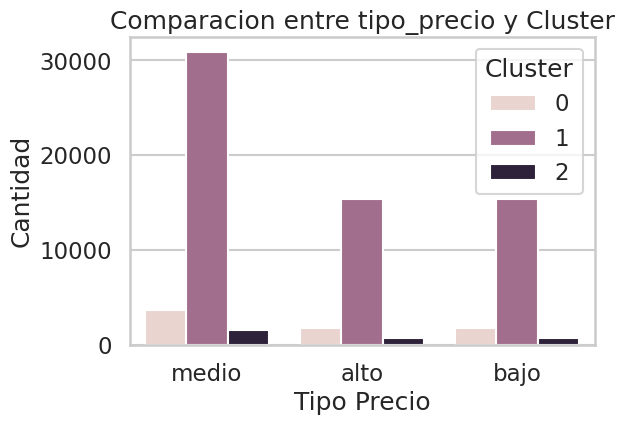

In [147]:
plotting = ds_target.copy()
plotting["Cluster"] = ds_cluster_3["Cluster"]

# Create the plot
plt.figure(figsize=(6, 4))
sns.countplot(data=plotting, x='tipo_precio', hue='Cluster')

# Add labels and title
plt.xlabel('Tipo Precio')
plt.ylabel('Cantidad')
plt.title('Comparacion entre tipo_precio y Cluster')

# Show the plot
plt.legend(title='Cluster')
plt.show()

Como descubrimos en el analisis de clusterizacion con k=3 en el Notebook numero 3, Los clusters se crearon a partir del tipo de propiedad, por lo que el anterior grafico nos muestra la cantidad de PHs, Departamentos y Casas dentro de cada categoria de precio.

**Clusters:**

* 0: PH
* 1: Departamento
* 2: Casa

Es decir se ve que la mayoria de propiedades, sea en bajo/medio/alto precio son departamentos, luego le siguen los PHs y luego las casas.

### Categorias de precios en el mapa de CABA

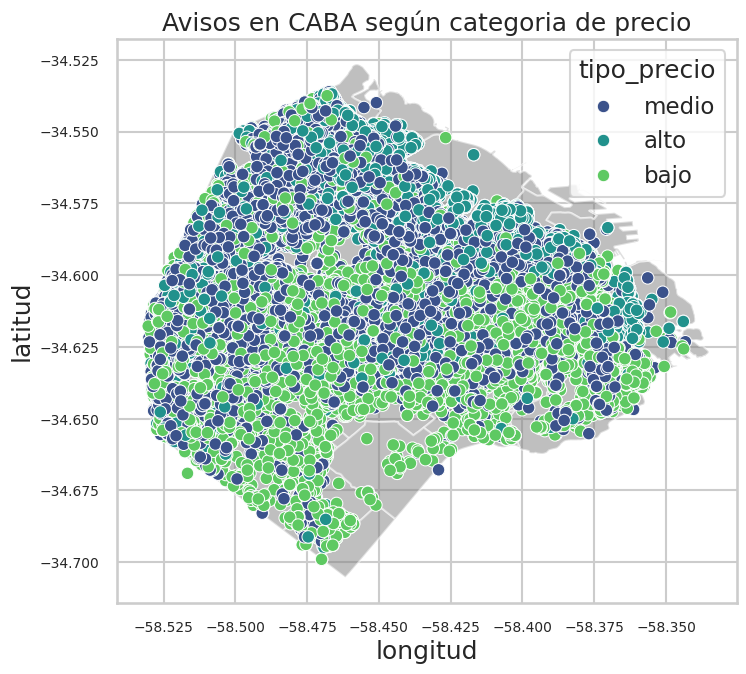

In [159]:
# setup GDF
ds_barrios['geometry'] = gpd.GeoSeries.from_wkt(ds_barrios['WKT'])
gdf_barrios = gpd.GeoDataFrame(ds_barrios, geometry='geometry')

fig, ax = plt.subplots(figsize=(8, 8))

# Graficar los límites de los barrios de CABA
gdf_barrios.plot(ax=ax, color='grey', alpha = 0.5)

# Graficar los puntos coloreados por cluster
sns.scatterplot(ax=ax, data=ds_target, x='longitud', y='latitud', hue='tipo_precio', palette='viridis')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Configurar título y etiquetas de los ejes
ax.set(title='Avisos en CABA según categoria de precio')
plt.show()

## Entrenamiento y Predicción

En esta sección se va a predecir el valor del atributo tipo_precio, excluyendo del entrenamiento la variable price,
pxm2 y cualquier otra que pueda contener información del precio de venta. Para todos los
modelos se pide realizar las tareas de ingeniería de características necesarias para trabajar
con cada algoritmo (encoding, normalización, etc).


### Modelo 1 : Árbol de decisión


#### Construcción
Construir un árbol de decisión y optimizar sus hiperparámetros mediante k-fold Cross
Validation para obtener la mejor performance. ¿Cuántos folds utilizaron? ¿Qué
métrica consideran adecuada para buscar los parámetros?

#### Gráfico
Graficar el árbol de decisión con mejor performance encontrado en el punto anterior.
Si es muy extenso mostrar una porción representativa.


#### Análisis
Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y
decisiones evaluadas (explicar las primeras reglas obtenidas).


#### Conclusión
Evaluar la performance del árbol en el conjunto de evaluación, explicar todas las
métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.

### Modelo 2: Random Forest


#### Construcción
Construir un clasificador RF y optimizar sus hiperparámetros mediante k-fold Cross
Validation para obtener la mejor performance. ¿Cuántos folds utilizaron? ¿Qué
métrica consideran adecuada para buscar los parámetros?

#### Análisis
Analizar la importancia de los atributos

#### Visualización
Mostrar la conformación final de uno de los árboles generados. Si es muy extenso
mostrar una porción representativa y explicar las primeras reglas.

#### Conclusión
Evaluar la performance del modelo en el conjunto de evaluación, explicar todas las
métricas y mostrar la matriz de confusión. Comparar con la performance de
entrenamiento.

### Modelo 3: a elección
En este punto se debe entrenar (mediante cross-validation) un modelo elegido por el
grupo. Se debe evaluar su performance en entrenamiento y sobre el conjunto de
evaluación, explicar todas las métricas y mostrar la matriz de confusión.

**¿Qué modelo elegirían para clasificar el tipo de precio de las propiedades?**